## Working with data

In [35]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt


In [36]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
  root ="data",
  train = True,
  download = True,
  transform = ToTensor(),
)

# Download test data from open datasets,
test_data = datasets.FashionMNIST(
  root="data",
  train = False,
  download = True,
  transform=ToTensor(),
)

# Function to display a batch of images
def show_images(images, labels, num_images=4):
    # Unnormalize the images if necessary (assuming they were normalized)
    # images = images * std + mean  # Uncomment and adjust if normalization was applied

    # Convert the batch of images to a grid
    img_grid = torchvision.utils.make_grid(images[:num_images], nrow=num_images)
    
    # Convert the grid to a numpy array and transpose the dimensions
    img_grid = img_grid.numpy().transpose((1, 2, 0))
    
    # Plot the grid
    plt.figure(figsize=(10, 4))
    plt.imshow(img_grid)
    plt.title('Sample Images from Test DataLoader')
    plt.axis('off')
    plt.show()

shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
shape of y: torch.Size([64]) <built-in method type of Tensor object at 0x31e78b7a0>


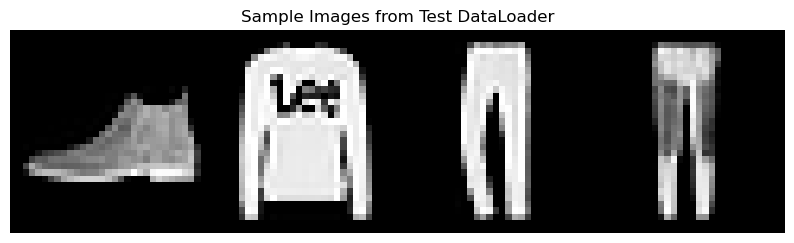

In [37]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"shape of X [N, C, H, W]: {X.shape}")
  print(f"shape of y: {y.shape} {y.type}")
  show_images(X, y, num_images=4)
  break


## Creating Models

In [26]:
# Get cpu, gpu or mps device for training.
device = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"

)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512,10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits
  
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [29]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.286817  [   64/60000]
loss: 2.282568  [ 6464/60000]
loss: 2.266541  [12864/60000]
loss: 2.277120  [19264/60000]
loss: 2.249187  [25664/60000]
loss: 2.215700  [32064/60000]
loss: 2.225198  [38464/60000]
loss: 2.185065  [44864/60000]
loss: 2.185690  [51264/60000]
loss: 2.167311  [57664/60000]
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.154995 

Epoch 2
-------------------------------
loss: 2.149534  [   64/60000]
loss: 2.146959  [ 6464/60000]
loss: 2.093741  [12864/60000]
loss: 2.125121  [19264/60000]
loss: 2.070948  [25664/60000]
loss: 2.001034  [32064/60000]
loss: 2.025791  [38464/60000]
loss: 1.941438  [44864/60000]
loss: 1.940474  [51264/60000]
loss: 1.889186  [57664/60000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.880911 

Epoch 3
-------------------------------
loss: 1.892779  [   64/60000]
loss: 1.874226  [ 6464/60000]
loss: 1.761399  [12864/60000]
loss: 1.816728  [19264/60000]
loss: 1.722449  [25664/60000]
loss: 1.652759  [32064/600

## Saving Models

In [31]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [32]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Predicted: "Ankle boot", Actual: "Ankle boot"


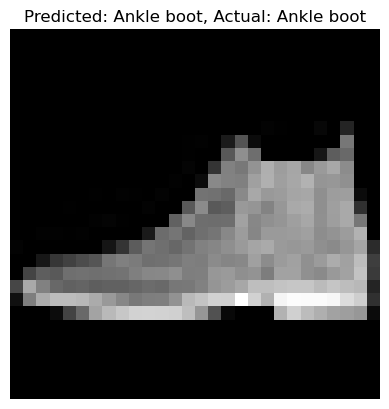

In [38]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    # Visualize the image
    plt.imshow(x.cpu().squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, Actual: {actual}')
    plt.axis('off')
    plt.show()



### Datasets & DataLoaders

### Iterating and Visualizing the Dataset

In [39]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

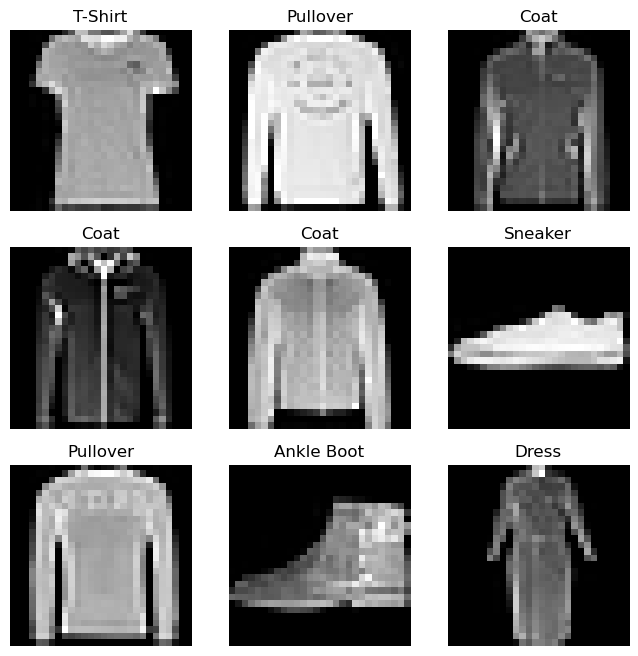

In [40]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

In [41]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __ init __

The __init__ is a special function used to set up newly created objects. It's part of a class definition and runs automatically when creating a new instance of the class.

##### The labels.csv file looks like:

- tshirt1.jpg, 0
- tshirt2.jpg, 0
- ankleboot999.jpg, 9

In [42]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

####  __ len __

 __ len __ is a special method that defines how the len() function behaves for class instances. Implementing __ len __ in your class enables objects to be passed to len(), returning an integer representing the object's size or number of elements.

In [43]:
# Example
def __len__(self):
    return len(self.img_labels)

### __ getitem __

The __getitem__ method in Python is a special function that defines how elements are accessed using square brackets ([]). Implementing __getitem__ in your class enables instances to support indexing and slicing, similar to built-in data structures like lists, tuples, and dictionaries.

In [44]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label


### Preparing your data for training with DataLoaders

In [45]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the Dataloader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


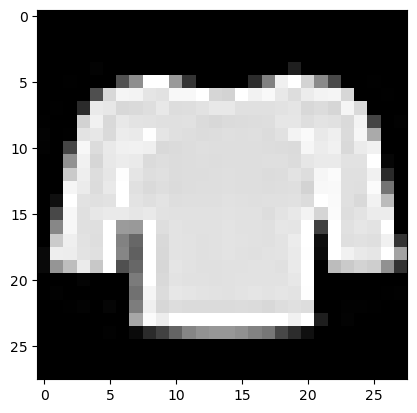

Label: 6


In [46]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Transforms

##### Data often requires preprocessing before it's suitable for training machine learning algorithms. Transforms help manipulate the data into the appropriate format.

TorchVision datasets include two parameters: 'transform' for modifying features and 'target_transform' for altering labels. These accept callables containing transformation logic. The torchvision.transforms module provides many ready-to-use transforms.

FashionMNIST features are in PIL Image format with integer labels. For training, we need normalized tensor features and one-hot encoded tensor labels. We use ToTensor and Lambda transforms to achieve these conversions.

In [47]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### To Tensor()

- ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

### Lambda Transforms

In PyTorch, Lambda transforms apply custom, user-defined transformations to data within the torchvision.transforms module. This feature offers flexibility for preprocessing steps not covered by torchvision's standard transformations. The Lambda transform takes a function as an argument and applies it to each dataset element.

In [48]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

### Build the Neural Network

### A  neural network consists of interconnected nodes (neurons) that process and learn from data through weighted connections. 

In [49]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##### `torch.nn` is a module in PyTorch that provides essential tools for building and training neural networks. It includes pre-defined layers, loss functions, and utilities to streamline the creation, customization, and optimization of deep learning models.

### Get Device for Training

In [50]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Define the Class

In [51]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [52]:
# Build the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [53]:
# Forward pass
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


### Model Layers

##### Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network

In [54]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten, nn.Linear, nn.ReLU, nn.Sequential, nn.Softmax

nn.Flatten converts multi-dimensional input tensors into 1-dimensional tensors in neural networks, particularly in PyTorch.

nn.Linear, also called a fully connected or dense layer, is a key component in neural networks. It performs linear transformations on input data, mapping it to an output space.

nn.ReLU (Rectified Linear Unit) is a popular activation function that introduces non-linearity into neural networks, essential for learning complex patterns.

nn.Sequential is a PyTorch container module that allows stacking layers in order, useful for building simple feed-forward neural networks where each layer's output becomes the next layer's input.

nn.Softmax is an activation function used in the final layer of classification models. It transforms raw output scores (logits) into probabilities, making them easier to interpret and use for decision-making.

In [55]:
flatten =  nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())
#nn.Linear 
layer1 = nn.Linear (in_features=28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(hidden1.size())
#nn.ReLU 
print(f"Before ReLU:  {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")
#nn.Sequential 
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
#nn.Softmax
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU:  tensor([[ 0.1667,  0.3507, -0.2780, -0.8173,  0.0154,  0.2413, -0.2055,  0.2247,
          0.0712,  0.3840, -0.4055,  0.4587, -0.5476,  0.3107,  0.5664,  0.2306,
         -0.2405,  0.4208,  0.4110, -0.5400],
        [ 0.1677,  0.3702, -0.1273, -0.3663, -0.1930, -0.0055, -0.3172,  0.2557,
         -0.3115,  0.3010, -0.7132,  0.3746, -0.7390,  0.2872,  0.1875, -0.2551,
         -0.2621,  0.5194,  0.7427, -0.7259],
        [ 0.0276,  0.4775,  0.0320, -0.6870,  0.1666,  0.0600, -0.2279,  0.1717,
         -0.2402,  0.4805, -0.6330,  0.2738, -0.2006, -0.0323,  0.4694, -0.3224,
         -0.2778,  0.4323,  0.4533, -0.4107]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.1667, 0.3507, 0.0000, 0.0000, 0.0154, 0.2413, 0.0000, 0.2247, 0.0712,
         0.3840, 0.0000, 0.4587, 0.0000, 0.3107, 0.5664, 0.2306, 0.0000, 0.4208,
         0.4110, 0.0000],
        [0.1677, 0.3702, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2557, 0.0000,
         0.

### Model Parameters

In [56]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0028,  0.0232,  0.0055,  ..., -0.0239,  0.0258, -0.0075],
        [-0.0210, -0.0166,  0.0223,  ..., -0.0144,  0.0143, -0.0240]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0185, -0.0147], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0351,  0.0166,  0.0196,  ..., -0.0130,  0.0286,  0.0379],
        [ 0.0120, -0.0275,  0.0270,  ..., -0.0050,  0.0123, -0.0168]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

### Automatic Differentiation with torch.autograd

In [57]:
import torch
x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad= True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [58]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x32d556770>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x32ce9f280>


### Computing Gradients

In [59]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0220, 0.1153, 0.0273],
        [0.0220, 0.1153, 0.0273],
        [0.0220, 0.1153, 0.0273],
        [0.0220, 0.1153, 0.0273],
        [0.0220, 0.1153, 0.0273]])
tensor([0.0220, 0.1153, 0.0273])


Note

 We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

### Disabling Gradient Tracking

By default, all tensors with requires_grad=True track their computational history and support gradient computation. However, in some cases, such as when applying a trained model to input data, we only need forward computations through the network. To stop tracking computations, we can wrap our code in a torch.no_grad() block.

In [60]:
z = torch.matmul(x,w)+b
print(z.requires_grad)

with torch.no_grad():
  z = torch.matmul(x,w)+b
print(z.requires_grad)

True
False


In [61]:
# Another way to achieve the same result is to use the detach() method on the tensor:
z = torch.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


### Optional Reading: Tensor Gradients and Jacobian Products

In [62]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


### Optimizing Model Parameters

In [63]:
# Prerequisite Code
# we load the code from the previous sections on Datasets and Data Loaders and Build Model.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Hyperparameters

In [64]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Loss Function

In [65]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

In [66]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Full Implementation
We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

In [67]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307523  [   64/60000]
loss: 2.293025  [ 6464/60000]
loss: 2.278761  [12864/60000]
loss: 2.272024  [19264/60000]
loss: 2.249800  [25664/60000]
loss: 2.232403  [32064/60000]
loss: 2.234823  [38464/60000]
loss: 2.202367  [44864/60000]
loss: 2.204806  [51264/60000]
loss: 2.186119  [57664/60000]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.170495 

Epoch 2
-------------------------------
loss: 2.175395  [   64/60000]
loss: 2.168750  [ 6464/60000]
loss: 2.118644  [12864/60000]
loss: 2.136604  [19264/60000]
loss: 2.081940  [25664/60000]
loss: 2.033845  [32064/60000]
loss: 2.061865  [38464/60000]
loss: 1.988104  [44864/60000]
loss: 1.995690  [51264/60000]
loss: 1.935891  [57664/60000]
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.924453 

Epoch 3
-------------------------------
loss: 1.945374  [   64/60000]
loss: 1.926251  [ 6464/60000]
loss: 1.810330  [12864/60000]
loss: 1.854075  [19264/60000]
loss: 1.738836  [25664/60000]
loss: 1.690559  [32064/600

### Save and Load the Model
In this section we will look at how to persist model state with saving, loading and running model predictions.



In [69]:
import torch
import torchvision.models as models

### Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:



In [70]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In the code below, we set weights_only=True to limit the functions executed during unpickling to only those necessary for loading weights. Using weights_only=True is considered a best practice when loading weights.

In [71]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

NOTE:
be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

### Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not model.state_dict()) to the saving function:

In [72]:
torch.save(model, 'model.pth')

We can then load the model as demonstrated below.

As described in Saving and loading torch.nn.Modules, saving state_dict``s is considered the best practice. However, below we use ``weights_only=False because this involves loading the model, which is a legacy use case for torch.save.

In [73]:
model = torch.load('model.pth', weights_only=False)

Note: 
This approach uses Python pickle module when serializing the model, thus it relies on the actual class definition to be available when loading the model.

### Pytorch Models

Here we will achieve the same result using pytorch models!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Looking over this code, we can spot some structural similarities with the diagram above.

This demonstrates the structure of a typical PyTorch model:
- It inherits from torch.nn.Module - modules may be nested - in fact, even the Conv2d and Linear layer classes inherit from torch.nn.Module.
- A model will have an __init__() function, where it instantiates its layers, and loads any data artifacts it might need (e.g., an NLP model might load a vocabulary).
- A model will have a forward() function. This is where the actual computation happens: An input is passed through the network layers and various functions to generate an output.
- Other than that, you can build out your model class like any other Python class, adding whatever properties and methods you need to support your model’s computation.

Let’s instantiate this object and run a sample input through it.

In [3]:
net = LeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 1, 32, 32)   # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # we don't call forward() directly
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[ 0.0851, -0.0153,  0.0974, -0.0303,  0.0129,  0.1163, -0.0890,  0.1027,
          0.1006, -0.0239]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


There are a few important things happening above:

- First, we instantiate the LeNet class, and we print the net object. A subclass of torch.nn.Module will report the layers it has created and their shapes and parameters. This can provide a handy overview of a model if you want to get the gist of its processing.

- Below that, we create a dummy input representing a 32x32 image with 1 color channel. Normally, you would load an image tile and convert it to a tensor of this shape.

- You may have noticed an extra dimension to our tensor - the batch dimension. PyTorch models assume they are working on batches of data - for example, a batch of 16 of our image tiles would have the shape (16, 1, 32, 32). Since we’re only using one image, we create a batch of 1 with shape (1, 1, 32, 32).

- We ask the model for an inference by calling it like a function: net(input). The output of this call represents the model’s confidence that the input represents a particular digit. (Since this instance of the model hasn’t learned anything yet, we shouldn’t expect to see any signal in the output.) Looking at the shape of output, we can see that it also has a batch dimension, the size of which should always match the input batch dimension. If we had passed in an input batch of 16 instances, output would have a shape of (16, 10).



### Datasets and Dataloaders

Below, we’re going to demonstrate using one of the ready-to-download, open-access datasets from TorchVision, how to transform the images for consumption by your model, and how to use the DataLoader to feed batches of data to your model.

The first thing we need to do is transform our incoming images into a PyTorch tensor.



In [4]:
#%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

Here, we specify two transformations for our input:

transforms.ToTensor() converts images loaded by Pillow into PyTorch tensors.

transforms.Normalize() adjusts the values of the tensor so that their average is zero and their standard deviation is 1.0. Most activation functions have their strongest gradients around x = 0, so centering our data there can speed learning. The values passed to the transform are the means (first tuple) and the standard deviations (second tuple) of the rgb values of the images in the dataset. You can calculate these values yourself by running these few lines of code:

from torch.utils.data import ConcatDataset transform = transforms.Compose([transforms.ToTensor()]) trainset = torchvision.datasets.CIFAR10(root=’./data’, train=True,

download=True, transform=transform)

#stack all train images together into a tensor of shape #(50000, 3, 32, 32) x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])

#get the mean of each channel mean = torch.mean(x, dim=(0,2,3)) #tensor([0.4914, 0.4822, 0.4465]) std = torch.std(x, dim=(0,2,3)) #tensor([0.2470, 0.2435, 0.2616])

There are many more transforms available, including cropping, centering, rotation, and reflection.

Next, we’ll create an instance of the CIFAR10 dataset. This is a set of 32x32 color image tiles representing 10 classes of objects: 6 of animals (bird, cat, deer, dog, frog, horse) and 4 of vehicles (airplane, automobile, ship, truck):

In [5]:
trainset = torchvision.datasets.CIFAR10(root= './data', train=True, download=True, transform=transform)

Files already downloaded and verified


This is an example of creating a dataset object in PyTorch. Downloadable datasets (like CIFAR-10 above) are subclasses of torch.utils.data.Dataset. Dataset classes in PyTorch include the downloadable datasets in TorchVision, Torchtext, and TorchAudio, as well as utility dataset classes such as torchvision.datasets.ImageFolder, which will read a folder of labeled images. You can also create your own subclasses of Dataset.

When we instantiate our dataset, we need to tell it a few things:

- The filesystem path to where we want the data to go.

- Whether or not we are using this set for training; most datasets will be split into training and test subsets.

- Whether we would like to download the dataset if we haven’t already.

- The transformations we want to apply to the data.

- Once your dataset is ready, you can give it to the DataLoader:

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

A  Dataset subclass wraps access to the data, and is specialized to the type of data it’s serving. The DataLoader knows nothing about the data, but organizes the input tensors served by the Dataset into batches with the parameters you specify.

In the example above, we’ve asked a DataLoader to give us batches of 4 images from trainset, randomizing their order (shuffle=True), and we told it to spin up two workers to load data from disk.

It’s good practice to visualize the batches your DataLoader serves:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane  deer   dog  frog


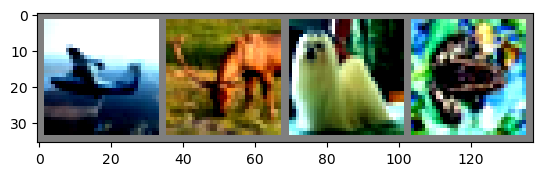

In [7]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Training our PyTorch Model

Let's put all the pieces together, and train a model:

In [1]:
#%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt 
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root= './data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We'll run our check on the output from DataLoader:

 frog truck   dog   car


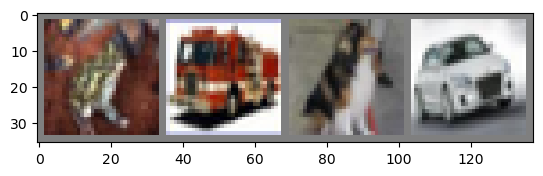

In [3]:
import matplotlib.pyplot as plt
import numpy as np
#functions to show an image

def imshow(img):
  img = img/ 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

#get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

This is the model we'll train.If it looks familiar, that's because it's a variant of LeNet

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

The last ingredients we need are a loss function and an optimizer:

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The loss function, as discussed earlier in this video, is a measure of how far from our ideal output the model’s prediction was. Cross-entropy loss is a typical loss function for classification models like ours.

The optimizer is what drives the learning. Here we have created an optimizer that implements stochastic gradient descent, one of the more straightforward optimization algorithms. Besides parameters of the algorithm, like the learning rate (lr) and momentum, we also pass in net.parameters(), which is a collection of all the learning weights in the model - which is what the optimizer adjusts.

Finally, all of this is assembled into the training loop. Go ahead and run this cell, as it will likely take a few minutes to execute:



In [6]:
for epoch in range(2): # loop over the dataset multiple times


  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    #get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()
    #forward+ backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: #print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i+1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.227
[1,  4000] loss: 1.887
[1,  6000] loss: 1.699
[1,  8000] loss: 1.600
[1, 10000] loss: 1.520
[1, 12000] loss: 1.466
[2,  2000] loss: 1.394
[2,  4000] loss: 1.363
[2,  6000] loss: 1.323
[2,  8000] loss: 1.290
[2, 10000] loss: 1.293
[2, 12000] loss: 1.260
Finished Training


- Here, we are doing only 2 training epochs (line 1) - that is, two passes over the training dataset. Each pass has an inner loop that iterates over the training data (line 4), serving batches of transformed input images and their correct labels.

- Zeroing the gradients (line 9) is an important step. Gradients are accumulated over a batch; if we do not reset them for every batch, they will keep accumulating, which will provide incorrect gradient values, making learning impossible.

- In line 12, we ask the model for its predictions on this batch. In the following line (13), we compute the loss - the difference between outputs (the model prediction) and labels (the correct output).

- In line 14, we do the backward() pass, and calculate the gradients that will direct the learning.

- In line 15, the optimizer performs one learning step - it uses the gradients from the backward() call to nudge the learning weights in the direction it thinks will reduce the loss.

- The remainder of the loop does some light reporting on the epoch number, how many training instances have been completed, and what the collected loss is over the training loop.

Note that the loss is monotonically descending, indicating that our model is continuing to improve its performance on the training dataset.

As a final step, we should check that the model is actually doing general learning, and not simply “memorizing” the dataset. This is called overfitting, and usually indicates that the dataset is too small (not enough examples for general learning), or that the model has more learning parameters than it needs to correctly model the dataset.

This is the reason datasets are split into training and test subsets - to test the generality of the model, we ask it to make predictions on data it hasn’t trained on:

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


Here, we see that the model is roughly 50% accurate at this point. That’s not exactly state-of-the-art, but it’s far better than the 10% accuracy we’d expect from a random output. This demonstrates that some general learning did happen in the model.

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anjalisuman/Documents/GitHub/ML101/img/cat.jpg'

Our ResNet model was trained on the ImageNet dataset, and expects images to be of a certain size, with the channel data normalized to a specific range of values. We’ll also pull in the list of human-readable labels for the categories our model recognizes - that should be in the img folder as well.



In [11]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

NameError: name 'test_img' is not defined

Now, we can ask the question: What does our model think this image represents?

In [12]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

NameError: name 'input_img' is not defined

We’ve confirmed that ResNet thinks our image of a cat is, in fact, a cat. But why does the model think this is an image of a cat?

For the answer to that, we turn to Captum.

### Feature Attribution with Integrated Gradients

Feature attribution attributes a particular output to features of the input. It uses a specific input - here, our test image - to generate a map of the relative importance of each input feature to a particular output feature.

Integrated Gradients is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model’s output with respect to the inputs.

In our case, we’re going to be taking a specific element of the output vector - that is, the one indicating the model’s confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we’ll use the visualization tools in Captum to give a helpful representation of the importance map. Captum’s visualize_image_attr() function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.

Running the cell with the integrated_gradients.attribute() call will usually take a minute or two.

In [13]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

NameError: name 'input_img' is not defined

n the image above, you should see that Integrated Gradients gives us the strongest signal around the cat’s location in the image.



### Feature Attribution with Occlusion

Gradient-based attribution methods help to understand the model in terms of directly computing out the output changes with respect to the input. Perturbation-based attribution methods approach this more directly, by introducing changes to the input to measure the effect on the output. Occlusion is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

Below, we set up Occlusion attribution. Similarly to configuring a convolutional neural network, you can specify the size of the target region, and a stride length to determine the spacing of individual measurements. We’ll visualize the output of our Occlusion attribution with visualize_image_attr_multiple(), showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions. The masking gives a very instructive view of what regions of our cat photo the model found to be most “cat-like”.

In [14]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

NameError: name 'input_img' is not defined

Again, we see greater significance placed on the region of the image that contains the cat.



### Layer Attribution with Layer GradCAM

Layer Attribution allows you to attribute the activity of hidden layers within your model to features of your input. Below, we’ll use a layer attribution algorithm to examine the activity of one of the convolutional layers within our model.

GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled and used to mask the input.

Layer attribution is set up similarly to input attribution, except that in addition to the model, you must specify a hidden layer within the model that you wish to examine. As above, when we call attribute(), we specify the target class of interest.

In [15]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

NameError: name 'input_img' is not defined

We’ll use the convenience method interpolate() in the LayerAttribution base class to upsample this attribution data for comparison to the input image.

In [16]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

NameError: name 'attributions_lgc' is not defined

Visualizations such as this can give you novel insights into how your hidden layers respond to your input.

### Visualization with Captum Insights

Captum Insights is an interpretability visualization widget built on top of Captum to facilitate model understanding. Captum Insights works across images, text, and other features to help users understand feature attribution. It allows you to visualize attribution for multiple input/output pairs, and provides visualization tools for image, text, and arbitrary data.

In this section of the notebook, we’ll visualize multiple image classification inferences with Captum Insights.

First, let’s gather some image and see what the model thinks of them. For variety, we’ll take our cat, a teapot, and a trilobite fossil:

In [17]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anjalisuman/Documents/GitHub/ML101/img/cat.jpg'

...and it looks like our model is identifying them all correctly - but of course, we want to dig deeper. For that we’ll use the Captum Insights widget, which we configure with an AttributionVisualizer object, imported below. The AttributionVisualizer expects batches of data, so we’ll bring in Captum’s Batch helper class. And we’ll be looking at images specifically, so well also import ImageFeature.

We configure the AttributionVisualizer with the following arguments:

An array of models to be examined (in our case, just the one)

A scoring function, which allows Captum Insights to pull out the top-k predictions from a model

An ordered, human-readable list of classes our model is trained on

A list of features to look for - in our case, an ImageFeature

A dataset, which is an iterable object returning batches of inputs and labels - just like you’d use for training



In [18]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

ModuleNotFoundError: No module named 'flask_compress'

Note that running the cell above didn’t take much time at all, unlike our attributions above. That’s because Captum Insights lets you configure different attribution algorithms in a visual widget, after which it will compute and display the attributions. That process will take a few minutes.

Running the cell below will render the Captum Insights widget. You can then choose attributions methods and their arguments, filter model responses based on predicted class or prediction correctness, see the model’s predictions with associated probabilities, and view heatmaps of the attribution compared with the original image.



In [19]:
visualizer.render()

NameError: name 'visualizer' is not defined